### Imports

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

### Input dataset

In [50]:
df_original = pd.read_csv('../data/02_processed/df_cleaned.csv')

### Functions

In [155]:
def add_cyclic_features(df: pd.DataFrame) -> pd.DataFrame:        
    df['hour_sin'] = np.sin(2 * np.pi * df['pickup_datetime_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['pickup_datetime_hour'] / 24)
    # df['dow_sin'] = np.sin(2 * np.pi * df['pickup_datetime_dayofweek'] / 7)
    # df['dow_cos'] = np.cos(2 * np.pi * df['pickup_datetime_dayofweek'] / 7)
    # df['month_sin'] = np.sin(2 * np.pi * df['pickup_datetime_month'] / 12)
    # df['month_cos'] = np.cos(2 * np.pi * df['pickup_datetime_month'] / 12)
    # df['doy_sin'] = np.sin(2 * np.pi * df['pickup_datetime_dayofyear'] / 366)
    # df['doy_cos'] = np.cos(2 * np.pi * df['pickup_datetime_dayofyear'] / 366)

    return df.drop(['pickup_datetime_hour', 'pickup_datetime_dayofweek',
                    'pickup_datetime_month', 'pickup_datetime_dayofyear'], axis=1)


In [156]:
def get_feature_lists() -> tuple[list[str], list[str], list[str]]:
    numeric = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
               'dropoff_latitude', 'trip_distance', 
                # 'passenger_count',
               'pickup_datetime_year']
    boolean = [
              #  'pickup_datetime_is_weekend', 
              #  'is_late_night', 
               'is_night',
              #  'is_early_morning',
                #  'is_rush_hour'
                ]
    cyclic = ['hour_sin', 'hour_cos', 
              # 'dow_sin', 'dow_cos',
            #   'month_sin', 'month_cos', 
              # 'doy_sin', 
            #   'doy_cos'
              ]
    return numeric, boolean, cyclic

In [157]:
def build_preprocessor(numeric: list[str], boolean: list[str], cyclic: list[str]) -> ColumnTransformer:
    
    try:
        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric),
            ('bool', 'passthrough', boolean),
            ('cyclic', 'passthrough', cyclic),
        ])
        return preprocessor
    except Exception as e:
        raise RuntimeError(f"Failed to build preprocessor: {e}")

### Preprocessing

In [164]:
df = df_original.copy()

In [165]:
df.shape

(19607065, 19)

In [166]:
df.columns

Index(['id', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_datetime_dayofyear', 'pickup_datetime_month',
       'pickup_datetime_year', 'pickup_datetime_hour',
       'pickup_datetime_dayofweek', 'pickup_datetime_is_weekend',
       'is_late_night', 'is_night', 'is_early_morning', 'is_rush_hour',
       'trip_distance'],
      dtype='object')

In [167]:
df['fare_amount'].describe()

count    1.960706e+07
mean     1.293649e+01
std      1.076349e+01
min      1.000000e-02
25%      7.000000e+00
50%      9.500000e+00
75%      1.450000e+01
max      9.520000e+02
Name: fare_amount, dtype: float64

In [168]:
df = add_cyclic_features(df)
numeric, boolean, cyclic = get_feature_lists()
all_features = numeric + boolean + cyclic
preprocessor = build_preprocessor(numeric, boolean, cyclic)

In [169]:
df = df.drop(columns=['id', 'pickup_datetime', 'is_rush_hour', 'passenger_count', ])

### Model training

In [170]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15685652, 12), (3921413, 12), (15685652,), (3921413,))

In [171]:
X_train_preprocessed

array([[-1.45376225e-01, -4.39308998e-01, -4.82203018e-01, ...,
         0.00000000e+00,  1.22464680e-16, -1.00000000e+00],
       [ 8.12014805e-01,  8.35682593e-01, -5.05060411e-01, ...,
         0.00000000e+00,  2.58819045e-01, -9.65925826e-01],
       [ 4.47732042e-01,  1.00040829e+00,  3.44064334e-01, ...,
         0.00000000e+00,  5.00000000e-01, -8.66025404e-01],
       ...,
       [-3.98304947e-01, -1.82865203e-01, -3.90975216e-01, ...,
         0.00000000e+00, -5.00000000e-01,  8.66025404e-01],
       [ 2.79968018e-01,  3.61059792e-01, -2.63544533e-01, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-5.20656661e-02,  1.98496127e-02,  5.27980086e+00, ...,
         0.00000000e+00, -1.00000000e+00, -1.83697020e-16]],
      shape=(15685652, 9))

In [172]:
version = "v7"
mlflow.set_experiment("LG_Notebook_NYC_Taxi")

with mlflow.start_run(run_name=f"LinearRegression_{version}"):
    model = LinearRegression()
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)

    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")

    feature_names = preprocessor.get_feature_names_out()
    mlflow.log_param("features", ", ".join(feature_names))
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("rmse", rmse)

    coefs = pd.DataFrame({"feature": feature_names, "coefficient": model.coef_})
    coefs_file = f"../data/feature_importance_{version}.csv"
    coefs.to_csv(coefs_file, index=False)
    mlflow.log_artifact(coefs_file)

    signature = infer_signature(X_train_preprocessed, model.predict(X_train_preprocessed))
    input_example = X_train_preprocessed[:5]

    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="model",
        signature=signature,
        input_example=input_example
    )

MSE: 17.5261, RMSE: 4.1864


### Shap values and coefficients

LinearExplainer explainer: 3921414it [00:21, 96826.50it/s]                              


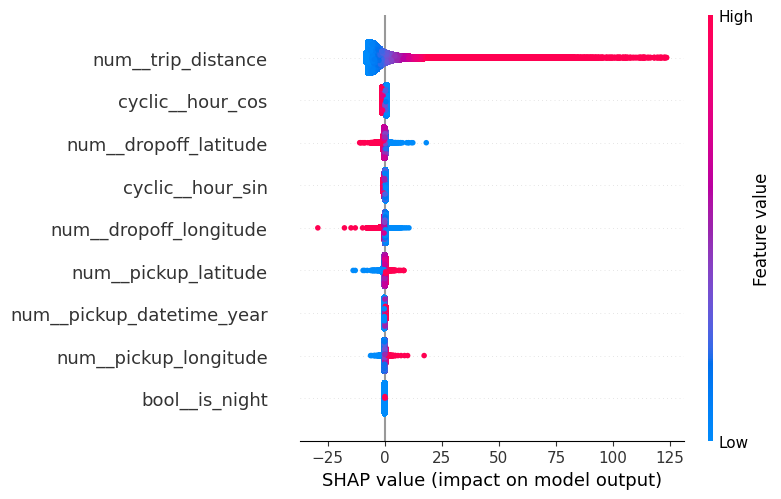

In [173]:
import shap

explainer = shap.Explainer(model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names)


C:\Users\Napsugar.Kelemen\AppData\Local\Temp\ipykernel_24588\139477176.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


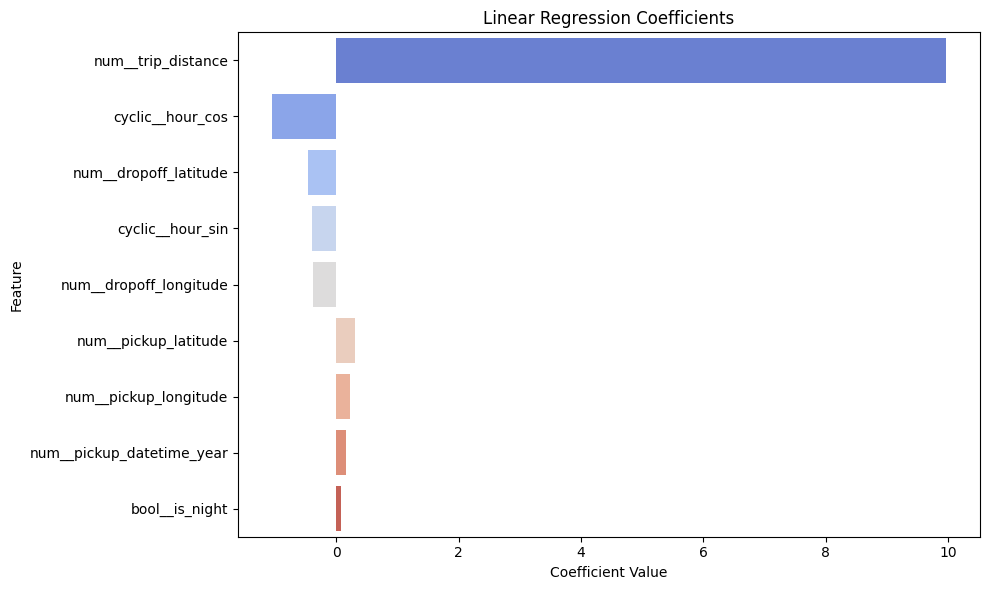

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by absolute value for better visualization
coefs["abs_coefficient"] = coefs["coefficient"].abs()
coefs_sorted = coefs.sort_values("abs_coefficient", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefs_sorted,
    x="coefficient",
    y="feature",
    palette="coolwarm",
    orient="h"
)

plt.title("Linear Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [175]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_test_preprocessed, y_test,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i]:<30}"
              f"{r.importances_mean[i]:.4f} +/- {r.importances_std[i]:.4f}")


num__trip_distance            1.7146 +/- 0.0010
cyclic__hour_cos              0.0098 +/- 0.0000
num__dropoff_latitude         0.0036 +/- 0.0000
num__dropoff_longitude        0.0025 +/- 0.0000
num__pickup_latitude          0.0016 +/- 0.0000
cyclic__hour_sin              0.0012 +/- 0.0000
num__pickup_longitude         0.0009 +/- 0.0000
num__pickup_datetime_year     0.0005 +/- 0.0000
bool__is_night                0.0000 +/- 0.0000
